# Implementing Transformers for Text Generation

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

## Set up the environment

In [7]:
import ssl
import certifi
import urllib.request

opener = urllib.request.build_opener(
    urllib.request.HTTPSHandler(context=ssl.create_default_context(cafile=certifi.where()))
)
urllib.request.install_opener(opener)

In [8]:
path_to_file = get_file('sharespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [9]:
vocab_size = 10000
seq_length = 100

vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

vectorized_text = vectorizer([text][0])
print('Vectorized text shape:', vectorized_text.shape)
print('First 10 vectorized tokens:', vectorized_text.numpy()[:10])

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


2025-10-19 15:39:55.151295: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Create input and target sequences

In [10]:
def create_sequences(text, seq_length):
  input_seqs = []
  target_seqs = []
  for i in range(len(text) - seq_length):
    input_seq = text[i:i + seq_length]
    target_seq = text[i + 1:i + seq_length + 1]
    input_seqs.append(input_seq)
    target_seqs.append(target_seq)
  return np.array(input_seqs), np.array(target_seqs)

X, Y = create_sequences(vectorized_text.numpy(), seq_length)

print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


## Build the transformer model

In the following code: 

- Define the TransformerBlock class that includes multi-head attention and feedforward layers with normalization and dropout. 

- Define the TransformerModel class, including embedding, positional encoding, and multiple Transformer blocks. 

- Compile the Transformer model using the Adam optimizer and sparse categorical cross-entropy loss function. 

In [12]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout, Layer
from tensorflow.keras.models import Model

class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential([
      Dense(ff_dim, activation='relu'),
      Dense(embed_dim)
    ])
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training=False):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):
  def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
    super(TransformerModel, self).__init__()
    self.embedding = Embedding(vocab_size, embed_dim)
    self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
    self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
    self.dense = Dense(vocab_size)

  def positional_encoding(self, seq_length, embed_dim):
    angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

  def get_angles(self, pos, i, embed_dim):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    return pos * angle_rates

  def call(self, inputs, training=False):
    seq_len = tf.shape(inputs)[1]
    x = self.embedding(inputs)
    x += self.pos_encoding[:, :seq_len, :]
    for transformer_block in self.transformer_blocks:
      x = transformer_block(x, training=training)
    output = self.dense(x)
    return output

## Build and compile the model

In [ ]:
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 100, 256)          │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 100, 10000)        │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

## Train the transformer model

In the following code: 

- Train the Transformer model on the input and target sequences 

- Plot the training loss to monitor the model's performance over epochs 

> **Note:** The original dataset is large, we have reduced it to 10,000 samples and limited the training to 2 epochs in order to minimize execution time


In [14]:
X = X[:10000]
Y = Y[:10000]

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - loss: 10.8172
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 309s 986ms/step - loss: 10.9099


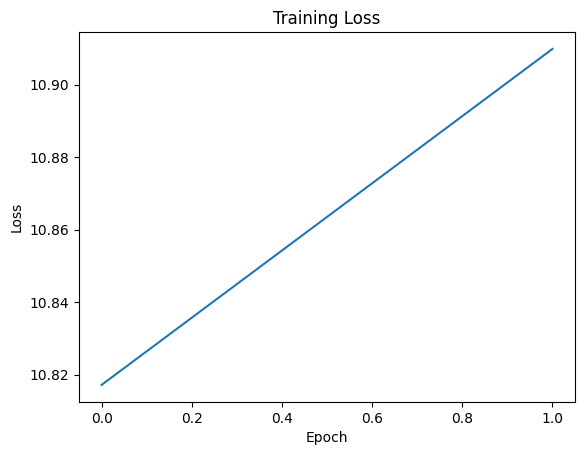

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Generate text with the trained model

In the following code: 

- Define the generate_text function to generate text using the trained Transformer model 

- Convert the start string into numerical format 

- Use the model to predict the next word and append it to the generated text 

- Print the generated text 

In [ ]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
  input_eval = vectorizer([start_string]).numpy()

  if input_eval.shape[1] < seq_length:
    # Pad the input if it's shorter than the expected sequence length
    padding = np.zeros((1, seq_length - input_eval.shape[1]))
    input_eval = np.concatenate((padding, input_eval), axis=1)
  elif input_eval.shape[1] > seq_length:
    input_eval = input_eval[:, -seq_length:]

  input_eval = tf.convert_to_tensor(input_eval)

  text_generated = []

  for i in range(num_generate):
    predictions = model(input_eval)

    # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
    predictions = predictions[0]  # This should be of shape [vocab_size]

    # Apply temperature to predictions
    predictions = predictions / temperature

    predicted_id = tf.random.categorical(predictions, num_samples=1)[0,0].numpy()

    input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
    input_eval = input_eval[:, -seq_length:]
    input_eval = tf.convert_to_tensor(input_eval)

    text_generated.append(vectorizer.get_vocabulary()[predicted_id])

  return start_string + ' ' + ' '.join(text_generated)

start_string = 'To be, or not to be'
generated_text = generate_text(model, start_string, temperature=0.7)
print(generated_text)

To be, or not to be cunning threw provoked let poesy talk unmade joy his am hourly mistrustful they wondrous again it second needles made wars virginalling overtake engage proud rotten stern portly time fairer alteration divines awaking jest unrespective bequeath they who kam limber ourselves tauntingly holla sword seventy time sackbuts plainer access gilded tediousness farthest guiltless nearer stopping validity time fiend devil wept believe inform virginviolator relieve spreading unluckily lewd lets you alexander negligent feverous should should anon compliment meat unswayable fiddler touching lamentations man ill must ambling seeing stories lecture crab thing gates slowwingd shreds thing [UNK] been solum time publishd he foaming


## Exercise 1

**Objective:** Implement different sequence lengths to understand their effect on the performance of the Transformer model. 

**Instructions:**

- Change the sequence length to 50 

- Preprocess the data set with the new sequence length 

- Train the model and compare the training loss 

In [18]:
# Preprocess the dataset 
vocab_size = 10000 
seq_length = 50 

# Adapt TextVectorization to full text 
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

# Vectorize the text 
vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)
X = X[:10000]
Y = Y[:10000]

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]
Number of sequences generated: 202596
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79]
Shape of X: (202596, 50)
Shape of Y: (202596, 50)


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 50, 256)           │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 50, 10000)         │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 489ms/step - loss: 11.4444
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 472ms/step - loss: 11.5532


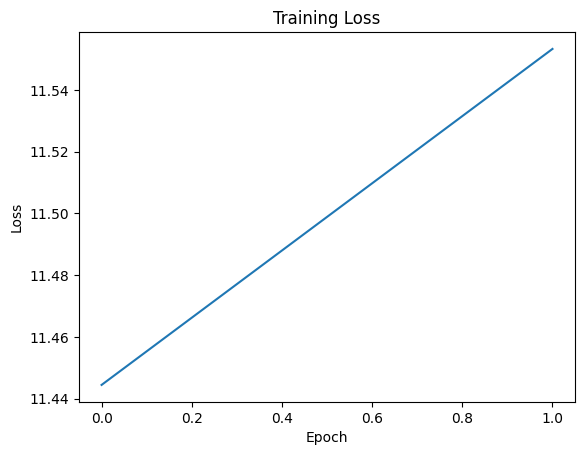

In [19]:
# Hyperparameters 
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

# Build the Transformer model 
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model 
model.summary()
# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Exercise 2

**Objective:** Implement a learning rate scheduler to adjust the learning rate during training. 

**Instructions:**

- Define a learning rate scheduler that reduces the learning rate by half every 10 epochs 

- Train the model with the learning rate scheduler and compare the training loss 

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 938ms/step - loss: 11.5123 - learning_rate: 0.0010
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 933ms/step - loss: 11.4814 - learning_rate: 0.0010


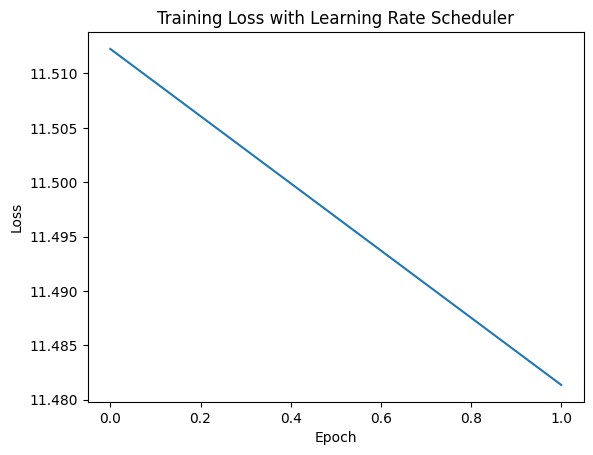

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define a learning rate scheduler  
def scheduler(epoch, lr):  
    if epoch % 10 == 0 and epoch != 0:  
        lr = lr * 0.5  
    return lr  

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  

# Train the model with the learning rate scheduler  
history = model.fit(X, Y, epochs=2, batch_size=64, callbacks=[callback])  

# Plot the training loss  
plt.plot(history.history['loss'])  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss with Learning Rate Scheduler')  
plt.show() 

## Exercise 3

**Objective:** To explore the model's text generation capabilities and generate longer sequences. 

**Instructions:**

- Modify the `generate_text` function to generate 200 tokens instead of 100 

- Generate text using the trained model and the modified function 


In [23]:
def generate_text(model, start_string, num_generate=200, temperature=1.0):
  input_eval = vectorizer([start_string]).numpy()

  if input_eval.shape[1] < seq_length:
    # Pad the input if it's shorter than the expected sequence length
    padding = np.zeros((1, seq_length - input_eval.shape[1]))
    input_eval = np.concatenate((padding, input_eval), axis=1)
  elif input_eval.shape[1] > seq_length:
    input_eval = input_eval[:, -seq_length:]

  input_eval = tf.convert_to_tensor(input_eval)

  text_generated = []

  for i in range(num_generate):
    predictions = model(input_eval)

    # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
    predictions = predictions[0]  # This should be of shape [vocab_size]

    # Apply temperature to predictions
    predictions = predictions / temperature

    predicted_id = tf.random.categorical(predictions, num_samples=1)[0,0].numpy()

    input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
    input_eval = input_eval[:, -seq_length:]
    input_eval = tf.convert_to_tensor(input_eval)

    text_generated.append(vectorizer.get_vocabulary()[predicted_id])

  return start_string + ' ' + ' '.join(text_generated)

start_string = 'To be, or not to be'
generated_text = generate_text(model, start_string, temperature=0.7)
print(generated_text)

To be, or not to be was was senator was bone was was only senator northeast where was was was was like usurers eight was was pitying shaft know impiety untoward was understanding was was home was romeobanished where where where when where tapsters thats was some tempted was where nestor where remiss when was thee was when where was where cease who was was was was was was was confident oxford was opposer was am thee prays vere was guildhall unwittingly striking where where thrown where echo meas stalls than turkey out where an was cominius thee ludlow where know where committed when where was was know was prowess was when was was weighd was thereabouts nightly was thee and [UNK] know was where when only severals obeys justices was when when senator good breath was know where was senator unmindful companion was only like rancour was where unpardonable saints when was thats weddingday was where was know skull was was where was where was was abuse was or when where maim nightcrow which sen